In [1]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Number of customers
num_customers = 100
transactions_per_customer = np.random.randint(1, 10, num_customers)

# Create empty list to store transactions
data = []

# Generate random transactions
for i, n in enumerate(transactions_per_customer, 1):
    for _ in range(n):
        transaction_amount = np.random.randint(50, 500)  # amount in dollars
        transaction_date = pd.Timestamp('2025-01-01') + pd.to_timedelta(np.random.randint(0, 365), unit='days')
        data.append([i, transaction_date, transaction_amount])

# Convert to DataFrame
df = pd.DataFrame(data, columns=['customer_id', 'transaction_date', 'amount'])

# Save to CSV
df.to_csv('customer_transactions.csv', index=False)

df.head()  # Show first 5 rows


,customer_id,transaction_date,amount
0,1,2025-04-11,276
1,1,2025-05-11,480
2,1,2025-01-05,306
3,1,2025-09-12,267
4,1,2025-12-25,447


In [2]:
# Load dataset
df = pd.read_csv('customer_transactions.csv')

# Convert transaction_date to datetime
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Show first 5 rows
df.head()


,customer_id,transaction_date,amount
0,1,2025-04-11,276
1,1,2025-05-11,480
2,1,2025-01-05,306
3,1,2025-09-12,267
4,1,2025-12-25,447


In [3]:
# Reference date for recency calculation
snapshot_date = df['transaction_date'].max() + pd.Timedelta(days=1)

# Group by customer
customer_df = df.groupby('customer_id').agg({
    'transaction_date': lambda x: (snapshot_date - x.max()).days,  # recency
    'customer_id': 'count',  # frequency
    'amount': ['mean', 'sum']  # AOV and total spend
})

# Rename columns
customer_df.columns = ['Recency', 'Frequency', 'AOV', 'Total_Spend']
customer_df.reset_index(inplace=True)

customer_df.head()


,customer_id,Recency,Frequency,AOV,Total_Spend
0,1,7,7,310.285714,2172
1,2,14,4,146.000000,584
2,3,39,8,258.000000,2064
3,4,196,5,237.800000,1189
4,5,18,7,325.000000,2275


In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Features (inputs) and target (LTV)
X = customer_df[['Recency', 'Frequency', 'AOV']]
y = customer_df['Total_Spend']

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost regressor
model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))


print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")


MAE: 57.06, RMSE: 81.90


In [10]:
# Predict LTV for all customers
customer_df['Predicted_LTV'] = model.predict(X)

# Segment customers into Low, Medium, High
customer_df['Segment'] = pd.qcut(customer_df['Predicted_LTV'], 3, labels=['Low', 'Medium', 'High'])

customer_df.head()


,customer_id,Recency,Frequency,AOV,Total_Spend,Predicted_LTV,Segment
0,1,7,7,310.285714,2172,2198.543213,High
1,2,14,4,146.000000,584,591.317017,Low
2,3,39,8,258.000000,2064,2036.547241,High
3,4,196,5,237.800000,1189,1191.770874,Medium
4,5,18,7,325.000000,2275,2266.251953,High


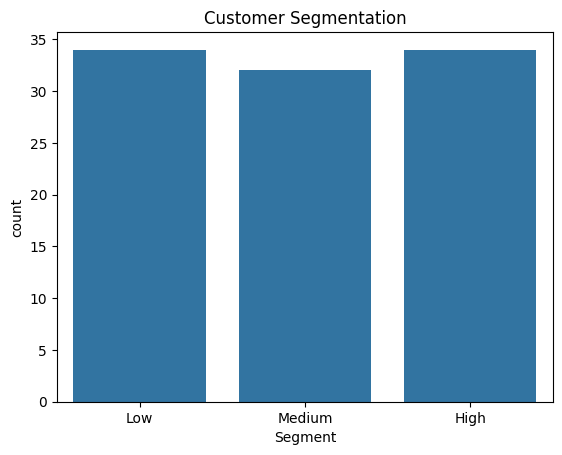

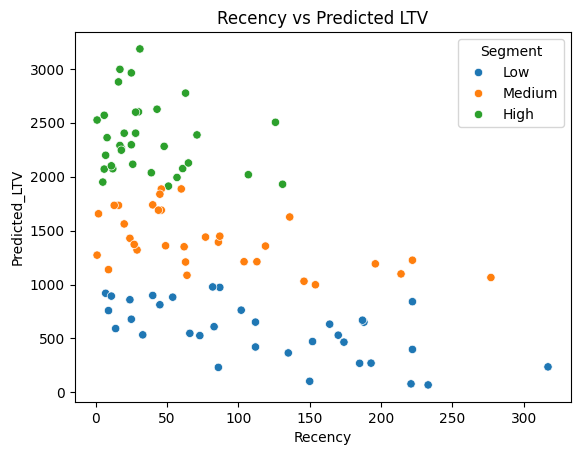

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Segment distribution
sns.countplot(data=customer_df, x='Segment')
plt.title('Customer Segmentation')
plt.show()

# Recency vs Predicted LTV
sns.scatterplot(data=customer_df, x='Recency', y='Predicted_LTV', hue='Segment')
plt.title('Recency vs Predicted LTV')
plt.show()


In [12]:
# Save predictions to CSV
customer_df.to_csv('LTV_predictions.csv', index=False)
